In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display

In [2]:
path = r'Acted Emotional Speech Dynamic Database'
list_path = []
for index,name in enumerate(os.listdir(path)):
    folder = os.path.join(path,name)
    for file_class in os.listdir(folder):
        in_folder = os.path.join(folder, file_class)
        list_path.append([in_folder,index])
    print(name,index)

fear 0
sadness 1
happiness 2
anger 3
disgust 4


In [3]:
df = pd.DataFrame(list_path,columns=['Path','label'])

In [4]:
df.head()

,Path,label
0,Acted Emotional Speech Dynamic Database/fear/f...,0
1,Acted Emotional Speech Dynamic Database/fear/f...,0
2,Acted Emotional Speech Dynamic Database/fear/f...,0
3,Acted Emotional Speech Dynamic Database/fear/f...,0
4,Acted Emotional Speech Dynamic Database/fear/f...,0


In [100]:
# Preprocessing functions
samples = sample_rate*5
def read_audio(path):
    '''
    Reads in the audio file and returns
    an array that we can turn into a melspectogram
    '''
    y, _ = librosa.core.load(path, sr=44100)
    # trim silence
    if 0 < len(y): # workaround: 0 length causes error
        y, _ = librosa.effects.trim(y)
    if len(y) > samples: # long enough
        y = y[0:0+samples]
    else: # pad blank
        padding = samples - len(y)
        offset = padding // 2
        y = np.pad(y, (offset, samples - len(y) - offset), 'constant')
    return y

def audio_to_melspectrogram(audio):
    '''
    Convert to melspectrogram after audio is read in
    '''
    spectrogram = librosa.feature.melspectrogram(audio, 
                                                 sr=22050,
                                                 n_mels=128,
                                                 hop_length=512,
                                                 )
    return librosa.power_to_db(spectrogram).astype(np.float32)

def read_as_melspectrogram(path):
    '''
    Convert audio into a melspectrogram 
    so we can use machine learning
    '''
    mels = audio_to_melspectrogram(read_audio(path))
    return mels

def convert_wav_to_image(df):
    X = []
    for _,row in tqdm_notebook(df.iterrows(), total = len(df)):
        x = read_as_melspectrogram(str(row['Path']))
        X.append(x.transpose())
    return X

def normalize(img):
    eps = 0.001
    if np.std(img) != 0:
        img = (img - np.mean(img)) / np.std(img)
    else:
        img = (img - np.mean(img)) / eps
    return img

def normalize_dataset(X):
    normalized_dataset = []
    for img in X:
        normalized = normalize(img)
        normalized_dataset.append(normalized)
    return normalized_dataset

In [101]:
# Preprocess dataset and create validation sets
from tqdm import tqdm_notebook as tqdm
X = np.array(convert_wav_to_image(df))
X = normalize_dataset(X)
y = df['label'].values

  0%|          | 0/604 [00:00<?, ?it/s]

<ipython-input-100-66dca732ad71>:24: FutureWarning: Pass y=[-2.9206170e-05 -3.3098022e-05 -4.0309005e-05 ...  6.4454824e-02
  5.5996019e-02 -7.9109780e-02] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectrogram = librosa.feature.melspectrogram(audio,
<ipython-input-100-66dca732ad71>:24: FutureWarning: Pass y=[-0.00244594 -0.0022397  -0.0020937  ... -0.07833488  0.01507805
  0.03651606] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectrogram = librosa.feature.melspectrogram(audio,
<ipython-input-100-66dca732ad71>:24: FutureWarning: Pass y=[-1.8429756e-04  9.7513199e-05 -5.8770180e-05 ...  2.0384789e-05
 -1.5616417e-05  1.7762184e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectrogram = librosa.feature.melspectrogram(audio,
<ipython-input-100-66dca732ad71>:24: FutureWarning: Pass y=[0. 0. 0. ... 0. 0. 0.] as keyword arg

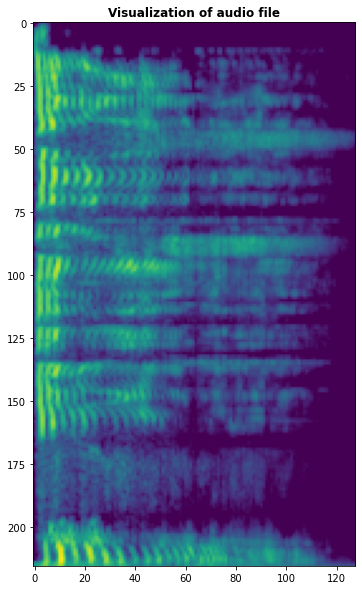

In [102]:
plt.figure(figsize=(15,10))
plt.title('Visualization of audio file', weight='bold')
plt.imshow(X[0]);

In [103]:
import pickle

with open('X_train.pkl', 'wb') as f:
    pickle.dump(X, f)
    
with open('y_train.pkl', 'wb') as x:
    pickle.dump(y, x)

In [104]:
X_ = [x for x in X]

In [119]:
X = np.array(X_)

In [120]:
from sklearn.preprocessing import OneHotEncoder
one_hot_label = OneHotEncoder()
y = one_hot_label.fit_transform(df[['label']])
y = y.toarray()
y.shape

(604, 5)

# LSTM

In [121]:
X.shape

(604, 216, 128)

In [122]:
y.shape

(604, 5)

In [123]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=23)

In [124]:
model = Sequential([
    LSTM(256,input_shape=(216,128)),
    Dense(128,activation='relu'),
    Dropout(0.2),
    Dense(64,activation='relu'),
    #Dropout(0.2),
    Dense(5,activation='softmax')
])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 256)               394240    
_________________________________________________________________
dense_9 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 325       
Total params: 435,717
Trainable params: 435,717
Non-trainable params: 0
_________________________________________________________________


In [125]:
history = model.fit(X,y,validation_data=(x_test,y_test),epochs=30,batch_size=32)

Epoch 1/30
19/19 [==============================] - 8s 326ms/step - loss: 1.6049 - accuracy: 0.2450 - val_loss: 1.4876 - val_accuracy: 0.3377
Epoch 2/30
19/19 [==============================] - 6s 320ms/step - loss: 1.4810 - accuracy: 0.3262 - val_loss: 1.3061 - val_accuracy: 0.5563
Epoch 3/30
19/19 [==============================] - 6s 335ms/step - loss: 1.3504 - accuracy: 0.4321 - val_loss: 1.1416 - val_accuracy: 0.5960
Epoch 4/30
19/19 [==============================] - 7s 360ms/step - loss: 1.3002 - accuracy: 0.4570 - val_loss: 1.2213 - val_accuracy: 0.5364
Epoch 5/30
19/19 [==============================] - 7s 345ms/step - loss: 1.1979 - accuracy: 0.5083 - val_loss: 1.0266 - val_accuracy: 0.6358
Epoch 6/30
19/19 [==============================] - 6s 336ms/step - loss: 1.1432 - accuracy: 0.5364 - val_loss: 0.9580 - val_accuracy: 0.6358
Epoch 7/30
19/19 [==============================] - 6s 337ms/step - loss: 1.0536 - accuracy: 0.5811 - val_loss: 0.9889 - val_accuracy: 0.5894
Epoch 

In [126]:
score = model.evaluate(x_test,y_test, verbose = 1) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])
score = model.evaluate(x_train, y_train, verbose = 1) 

print('Train loss:', score[0]) 
print('Train accuracy:', score[1])

5/5 [==============================] - 1s 98ms/step - loss: 0.1094 - accuracy: 0.9603
Test loss: 0.1093987450003624
Test accuracy: 0.9602649211883545
15/15 [==============================] - 2s 101ms/step - loss: 0.0806 - accuracy: 0.9801
Train loss: 0.08062205463647842
Train accuracy: 0.9801324605941772


In [129]:
y_predict = model.predict(x_test)
y_predict_bool = np.argmax(y_predict,axis=1).tolist()
y_test_e = np.argmax(y_test,axis=1).tolist()

In [130]:
from sklearn.metrics import precision_score,recall_score,confusion_matrix,classification_report
print(confusion_matrix(y_test_e,y_predict_bool))

[[24  0  0  0  0]
 [ 0 37  0  0  0]
 [ 3  0 30  0  0]
 [ 0  0  0 30  0]
 [ 1  0  2  0 24]]


In [131]:
print(classification_report(y_test_e,y_predict_bool))

              precision    recall  f1-score   support

           0       0.86      1.00      0.92        24
           1       1.00      1.00      1.00        37
           2       0.94      0.91      0.92        33
           3       1.00      1.00      1.00        30
           4       1.00      0.89      0.94        27

    accuracy                           0.96       151
   macro avg       0.96      0.96      0.96       151
weighted avg       0.96      0.96      0.96       151



In [132]:
model.save('lstm_spectogram_Spectogram-Copy2.h5')